In [1]:
%matplotlib inline

import os
import random

from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import professor as prof

import seaborn as sns

import numpy as np
import pandas as pd
import cv2
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [2]:
# get the list of filenames in a given directory

camera_view = 'KL11-E1DC'

availible_ids = [int(file.split('.')[0])
                 for file in os.listdir(f"./data/real/{camera_view}/") 
                 if file.endswith(".png")]

print(f'number of unique images: {len(availible_ids)}')
print(f'number of pairs: {len(availible_ids)*len(availible_ids)-1}')

number of unique images: 109
number of pairs: 11880


In [3]:
def downsample(img):
    return cv2.pyrDown(img)

In [4]:
def correct_contrast(img, clip_limit=3.2, tile_size=5):
    
    # create the object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, 
                            tileGridSize=(tile_size, tile_size))
    
    # apply equalisation
    return clahe.apply(img)

In [5]:
def nlm_filter(img, strength=7.4, window_size=4):
    return cv2.fastNlMeansDenoising(img, h=strength, searchWindowSize=window_size)

In [6]:
def blur(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

In [7]:
def noise(img):
    isNoise = 0
    i = 0
    j = 0
    criticalValue = 0.4
    for row in img:
        for col in row:
            if(j+1 == len(row)):
                break
            elif(np.abs(img[i,j]) == 0 or np.abs(img[i,j+1]) == 0):
                pass
            elif(np.abs(1 - int(img[i,j])/(int(img[i,j+1]))) > criticalValue):
                isNoise += 1
            j +=1
        i +=1
    return isNoise

In [90]:
def get_noise_bl(img):
    smooth = cv2.bilateralFilter(img, d=3,
                            sigmaColor=50,
                            sigmaSpace=50)
    
    diff = np.abs(img.astype(int) - smooth.astype(int))
    return diff.mean()

In [18]:
def draw_image_histogram(image, channels):
    hist = cv2.calcHist([image], channels, None, [256], [0, 256])
    hist = cv2.normalize(hist, None)
    return hist

In [19]:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.0*sigma**2))

In [130]:
def hist_params(img):
    histImage = draw_image_histogram(img, [0])
    bin_centres = np.arange(0,len(histImage))
    histImage = np.array([i[0] for i in histImage])
    mean = sum(bin_centres * histImage)
    sigma = sum(bin_centres * (histImage - mean)**2)
    
    p0 = [1.0, 126, 50]
    coeff, var_matrix = curve_fit(gauss, bin_centres, histImage, p0=p0)
    
    return coeff[1], coeff[2], mean

In [21]:
training_images = []
N = len(availible_ids)

for i in range(0,N):
    img_id = availible_ids[i]
    training_images.append(cv2.imread(f'./data/real/{camera_view}/{img_id}.png', 
                      cv2.IMREAD_GRAYSCALE))

downsampled = []
for image in training_images:
    downsampled.append(downsample(image))

In [22]:
def correct_contrast(img, clip_limit=3.2, tile_size=5):
    
    # create the object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, 
                            tileGridSize=(tile_size, tile_size))
    
    # apply equalisation
    return clahe.apply(img)

In [23]:
# wrap opencv functions so they are compatible with plots
def bilateral_filter(img, filter_size=5, sigma=70):
    
    # it's not clear exactly what the parameters represent in the docs...
    # (the sigmaSpace parameter appears to be superfluous)
    return cv2.bilateralFilter(img, d=filter_size,
                               sigmaColor=sigma,
                               sigmaSpace=sigma)

def nlm_filter(img, strength=2.5, window_size=6):
    return cv2.fastNlMeansDenoising(img, h=strength, searchWindowSize=window_size)

In [24]:
from __future__ import division
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from skimage import img_as_float


def _unsharp_mask_single_channel(image, radius, amount, vrange):
    """Single channel implementation of the unsharp masking filter."""

    blurred = gaussian_filter(image,
                              sigma=radius,
                              mode='reflect')

    result = image + (image - blurred) * amount
    if vrange is not None:
        return np.clip(result, vrange[0], vrange[1], out=result)
    result = result*255
    result = result.astype(np.uint8)
    return result


def unsharp_mask(image, radius=15.0, amount=2.0, multichannel=False,
                 preserve_range=False):
    vrange = None  # Range for valid values; used for clipping.
    if preserve_range:
        fimg = image.astype(np.float)
    else:
        fimg = img_as_float(image)
        negative = np.any(fimg < 0)
        if negative:
            vrange = [-1., 1.]
        else:
            vrange = [0., 1.]

    if multichannel:
        result = np.empty_like(fimg, dtype=np.float)
        for channel in range(image.shape[-1]):
            result[..., channel] = _unsharp_mask_single_channel(
                fimg[..., channel], radius, amount, vrange)
        result = result*255
        result = result.astype(np.uint8)
        return result
    else:
        result = _unsharp_mask_single_channel(fimg, radius, amount, vrange)
        result = result*255
        result = result.astype(np.uint8)
        return result

# Clustering without normalised parameters

This clusters the data using the noise, variance of the histogram, the skew of the histogram and the blur of the histogram.

In [250]:
params = []
from sklearn import preprocessing

for image in training_images:
    loc = []
    loc.append(noise(image))
    mean, var, skmean = hist_params(image)
    skew = mean - skmean
    loc.append(var)
    loc.append(skew)
    loc.append(blur(image))
    params.append(loc)

In [251]:
from sklearn.cluster import KMeans
nbrs = KMeans(n_clusters=4).fit(params)
labels = nbrs.labels_
print(labels)

[0 3 1 3 2 0 0 0 3 1 3 0 2 1 3 3 3 0 0 0 1 3 3 0 3 0 3 1 1 3 1 3 1 3 3 3 3
 1 3 0 3 3 3 0 3 3 3 3 3 1 0 3 0 1 2 1 0 0 3 3 1 2 3 3 1 0 0 3 3 3 1 1 0 0
 1 1 0 3 0 3 3 1 0 1 3 3 0 1 0 1 3 3 3 3 1 0 1 1 1 3 0 1 1 0 1 0 1 1 0]


Then the preprocessing is applied separately to each cluster and the parameters are recalculated to see how they have changed.

In [262]:
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster0prepro = []
cluster1prepro = []
cluster2prepro = []
cluster3prepro = []
total = 0

for i,n in enumerate(labels):
    if n == 0:
        cluster0.append(training_images[i])
    elif n == 1:
        cluster1.append(training_images[i])
    elif n == 2:
        cluster2.append(training_images[i])
    elif n == 3:
        cluster3.append(training_images[i])
    total += 1

for n,i in enumerate(cluster0):
    down = downsample(i)
    unsharped = unsharp_mask(down,7,1)
    nlmed = bilateral_filter(unsharped,9,8)
    bilated = nlm_filter(nlmed,6,5)
    corconed = correct_contrast(bilated,3,6)
    cluster0prepro.append(corconed)
    cv2.imwrite('Cluster_0/Before/img_'+str(n)+'.png',i)    
    cv2.imwrite('Cluster_0/After/img_'+str(n)+'.png',corconed)
    
for n,i in enumerate(cluster2):
    down = downsample(i)
    unsharped = unsharp_mask(down,6,2)
    nlmed = bilateral_filter(unsharped,10,9)
    bilated = nlm_filter(nlmed,10,8)
    corconed = correct_contrast(bilated,2,6)
    cluster2prepro.append(corconed)
    cv2.imwrite('Cluster_2/Before/img_'+str(n)+'.png',i)
    cv2.imwrite('Cluster_2/After/img_'+str(n)+'.png',corconed)
    
for n,i in enumerate(cluster3):
    down = downsample(i)
    unsharped = unsharp_mask(down,4,1)
    nlmed = bilateral_filter(unsharped,2,5)
    bilated = nlm_filter(nlmed,12,6)
    corconed = correct_contrast(bilated,2,9)
    cluster3prepro.append(corconed)
    cv2.imwrite('Cluster_3/Before/img_'+str(n)+'.png',i)
    cv2.imwrite('Cluster_3/After/img_'+str(n)+'.png',corconed)
    
for n,i in enumerate(cluster1):
    down = downsample(i)
    unsharped = unsharp_mask(down,5,2)
    nlmed = bilateral_filter(unsharped,3,4)
    bilated = nlm_filter(nlmed,12,7)
    corconed = correct_contrast(bilated,2,5)
    cluster1prepro.append(corconed)
    cv2.imwrite('Cluster_1/Before/img_'+str(n)+'.png',i)   
    cv2.imwrite('Cluster_1/After/img_'+str(n)+'.png',corconed)

In [263]:
newparams0 = []
newparams1 = []
newparams2 = []
newparams3 = []

for image in cluster0prepro:
    loc = []
    loc.append(noise(image))
    mean, var, skmean = hist_params(image)
    skew = mean - skmean
    loc.append(var)
    loc.append(skew)
    loc.append(blur(image))
    newparams0.append(loc)

for image in cluster1prepro:
    loc = []
    loc.append(noise(image))
    mean, var, skmean = hist_params(image)
    skew = mean - skmean
    loc.append(var)
    loc.append(skew)
    loc.append(blur(image))
    newparams1.append(loc)
    
for image in cluster2prepro:
    loc = []
    loc.append(noise(image))
    mean, var, skmean = hist_params(image)
    skew = mean - skmean
    loc.append(var)
    loc.append(skew)
    loc.append(blur(image))
    newparams2.append(loc)

for image in cluster3prepro:
    loc = []
    loc.append(noise(image))
    mean, var, skmean = hist_params(image)
    skew = mean - skmean
    loc.append(var)
    loc.append(skew)
    loc.append(blur(image))
    newparams3.append(loc)

## Noise vs Blur

The noise vs blur graph has some clear clusters that we can see emerging. Indicating that maybe this clustering is doing something useful! The parameters also seem to group together into a much tighter range and so this preprocessing is obviously acting on each image in a similar fashion.

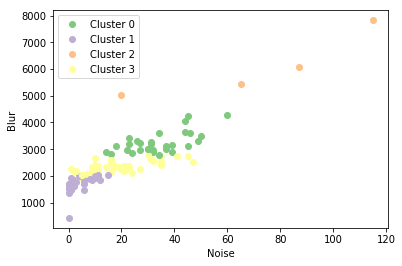

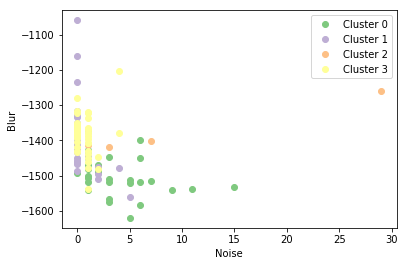

In [264]:
cmap = plt.cm.Accent
for i,n in enumerate(labels):
    plt.plot(params[i][0], params[i][3], 'o', color=cmap(labels[i]))
for i in range(0,4):
    plt.plot([], [], 'o', color=cmap(i), label='Cluster ' + str(i))
plt.legend()
plt.xlabel('Noise')
plt.ylabel('Blur')
plt.show()

for i in range(0,len(newparams0)):
        plt.plot(newparams0[i][0],newparams0[i][2],'o',color=cmap(0))
for i in range(0,len(newparams1)):
        plt.plot(newparams1[i][0],newparams1[i][2],'o',color=cmap(1))
for i in range(0,len(newparams2)):
        plt.plot(newparams2[i][0],newparams2[i][2],'o',color=cmap(2))
for i in range(0,len(newparams3)):
        plt.plot(newparams3[i][0],newparams3[i][2],'o',color=cmap(3))
for i in range(0,4):
    plt.plot([], [], 'o', color=cmap(i), label='Cluster ' + str(i))
plt.legend()
plt.xlabel('Noise')
plt.ylabel('Blur')
plt.show()

## Noise vs Histogram Variance

Here we can also see some nice clustering, not as prominent as the blur vs noise but still promising.

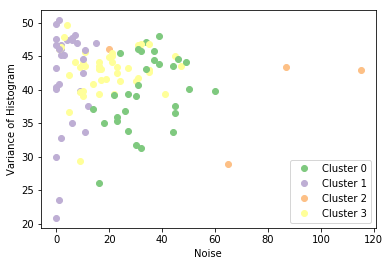

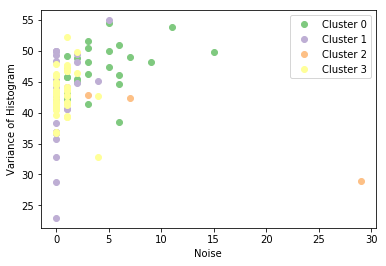

In [261]:
cmap = plt.cm.Accent
for i in range(0,len(labels)):
        plt.plot(params[i][0],params[i][1],'o',color=cmap(labels[i]))
for i in range(0,4):
    plt.plot([], [], 'o', color=cmap(i), label='Cluster ' + str(i))
plt.legend()
plt.xlabel('Noise')
plt.ylabel('Variance of Histogram')
plt.show()

cmap = plt.cm.Accent

for i in range(0,len(newparams0)):
        plt.plot(newparams0[i][0],newparams0[i][1],'o',color=cmap(0))
for i in range(0,len(newparams1)):
        plt.plot(newparams1[i][0],newparams1[i][1],'o',color=cmap(1))
for i in range(0,len(newparams2)):
        plt.plot(newparams2[i][0],newparams2[i][1],'o',color=cmap(2))
for i in range(0,len(newparams3)):
        plt.plot(newparams3[i][0],newparams3[i][1],'o',color=cmap(3))
for i in range(0,4):
    plt.plot([], [], 'o', color=cmap(i), label='Cluster ' + str(i))
plt.legend()
plt.xlabel('Noise')
plt.ylabel('Variance of Histogram')
plt.show()

## Noise vs Skew of Histogram

Again, we can see some clusters but not as clear cut as in the other dimensions.

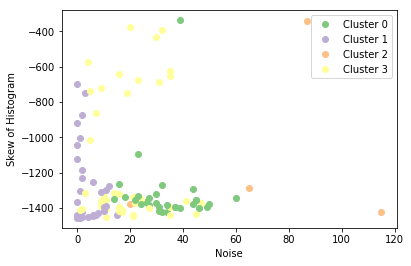

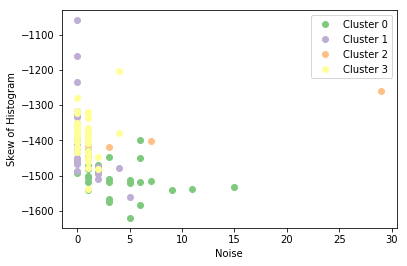

In [265]:
cmap = plt.cm.Accent
for i in range(0,len(labels)):
        plt.plot(params[i][0],params[i][2],'o',color=cmap(labels[i]))
for i in range(0,4):
    plt.plot([], [], 'o', color=cmap(i), label='Cluster ' + str(i))
plt.legend()
plt.xlabel('Noise')
plt.ylabel('Skew of Histogram')
plt.show()

for i in range(0,len(newparams0)):
        plt.plot(newparams0[i][0],newparams0[i][2],'o',color=cmap(0))
for i in range(0,len(newparams1)):
        plt.plot(newparams1[i][0],newparams1[i][2],'o',color=cmap(1))
for i in range(0,len(newparams2)):
        plt.plot(newparams2[i][0],newparams2[i][2],'o',color=cmap(2))
for i in range(0,len(newparams3)):
        plt.plot(newparams3[i][0],newparams3[i][2],'o',color=cmap(3))
for i in range(0,4):
    plt.plot([], [], 'o', color=cmap(i), label='Cluster ' + str(i))
plt.legend()
plt.xlabel('Noise')
plt.ylabel('Skew of Histogram')
plt.show()

# Clustering with normalised parameters

We now normalise the parameters so that each one has the same weighting when clustering. Taking away the bias of Euclidean space.

In [302]:
params = []
from sklearn import preprocessing

for image in training_images:
    loc = []
    mean, var, skmean = hist_params(image)
    skew = mean - skmean
    loc.append(var)
    loc.append(blur(image))
    params.append(loc)

min_max_scaler = preprocessing.MinMaxScaler()
params = min_max_scaler.fit_transform(params)

In [303]:
from sklearn.cluster import KMeans
nbrs = KMeans(n_clusters=4).fit(params)
labels_norm = nbrs.labels_
print(labels_norm)

[0 1 1 0 3 2 0 1 0 2 1 1 3 0 0 0 0 0 3 1 1 2 0 1 0 1 0 1 1 0 1 1 2 0 0 0 1
 0 0 0 0 0 0 3 1 0 0 0 0 0 2 0 2 0 3 0 1 0 1 1 0 3 0 1 0 1 3 1 0 1 1 0 0 1
 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 2 1 0 0 1 0 1 0 2 0 0 1 0 0 0]


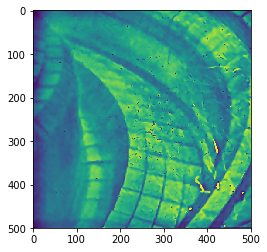

In [411]:
for i in [5]:
    down = downsample(training_images[i])
    nlmed = bilateral_filter(down,7,6)
    unsharped = unsharp_mask(nlmed,3.3,3)
    bilated = nlm_filter(unsharped,10,9)
    corconed = correct_contrast(bilated,3.5,8)
    plt.imshow(corconed,vmin=0,vmax=255)
    plt.gca()
    plt.show()

Now, the preprocessing for each cluster...

In [413]:
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster0prepro = []
cluster1prepro = []
cluster2prepro = []
cluster3prepro = []
total = 0

for i,n in enumerate(labels_norm):
    if n == 0:
        cluster0.append(training_images[i])
    elif n == 1:
        cluster1.append(training_images[i])
    elif n == 2:
        cluster2.append(training_images[i])
    elif n == 3:
        cluster3.append(training_images[i])
    total += 1

for n,i in enumerate(cluster1):
    down = downsample(i)
    nlmed = bilateral_filter(down,7,6)
    unsharped = unsharp_mask(nlmed,3,3)
    bilated = nlm_filter(unsharped,8,9)
    corconed = correct_contrast(bilated,3.5,8)
    cluster1prepro.append(corconed)
    cv2.imwrite('Cluster_1_norm/Before/img_'+str(n)+'.png',i)    
    cv2.imwrite('Cluster_1_norm/After/img_'+str(n)+'.png',corconed)
    
for n,i in enumerate(cluster2):
    down = downsample(i)
    nlmed = bilateral_filter(down,7,6)
    unsharped = unsharp_mask(nlmed,3.3,3)
    bilated = nlm_filter(unsharped,10,9)
    corconed = correct_contrast(bilated,3.5,8)
    cluster2prepro.append(corconed)
    cv2.imwrite('Cluster_2_norm/Before/img_'+str(n)+'.png',i)
    cv2.imwrite('Cluster_2_norm/After/img_'+str(n)+'.png',corconed)
    
for n,i in enumerate(cluster3):
    down = downsample(i)
    unsharped = unsharp_mask(down,5,1)
    nlmed = bilateral_filter(unsharped,2,5)
    bilated = nlm_filter(nlmed,12,6)
    corconed = correct_contrast(bilated,3,9)
    cluster3prepro.append(corconed)
    cv2.imwrite('Cluster_3_norm/Before/img_'+str(n)+'.png',i)
    cv2.imwrite('Cluster_3_norm/After/img_'+str(n)+'.png',corconed)
    
for n,i in enumerate(cluster0):
    down = downsample(i)
    nlmed = bilateral_filter(down,7,8)
    unsharped = unsharp_mask(nlmed,4,3)
    bilated = nlm_filter(unsharped,9,8)
    corconed = correct_contrast(bilated,3,8)
    cluster0prepro.append(corconed)
    cv2.imwrite('Cluster_0_norm/Before/img_'+str(n)+'.png',i)
    cv2.imwrite('Cluster_0_norm/After/img_'+str(n)+'.png',corconed)

Calculate the new parameters to see how the clustering has changed

In [294]:
newparams0 = []
newparams1 = []
newparams2 = []
newparams3 = []

for image in cluster0prepro:
    loc = []
    mean, var, skmean = hist_params(image)
    skew = mean - skmean
    loc.append(var)
    loc.append(skew)
    loc.append(blur(image))
    newparams0.append(loc)
    
newparams0 = min_max_scaler.fit_transform(newparams0)

for image in cluster1prepro:
    loc = []
    mean, var, skmean = hist_params(image)
    skew = mean - skmean
    loc.append(var)
    loc.append(skew)
    loc.append(blur(image))
    newparams1.append(loc)
    
newparams1 = min_max_scaler.fit_transform(newparams1)
    
for image in cluster2prepro:
    loc = []
    mean, var, skmean = hist_params(image)
    skew = mean - skmean
    loc.append(var)
    loc.append(skew)
    loc.append(blur(image))
    newparams2.append(loc)
    
newparams2 = min_max_scaler.fit_transform(newparams2)

for image in cluster3prepro:
    loc = []
    mean, var, skmean = hist_params(image)
    skew = mean - skmean
    loc.append(var)
    loc.append(skew)
    loc.append(blur(image))
    newparams3.append(loc)

newparams3 = min_max_scaler.fit_transform(newparams3)

## Blur vs Variance of Histogram

The clusters in the parameter space of blur vs Variance are presented here. As we can see using the normalised parameters, clusters appear when we use only two parameters to classify the images. This is good and bad and so will need homographies to tell us which is better.

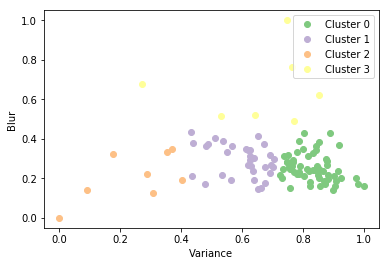

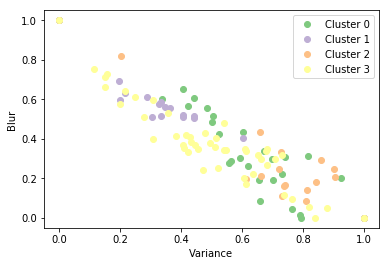

In [418]:
cmap = plt.cm.Accent
for i,n in enumerate(labels_norm):
    plt.plot(params[i][0], params[i][1], 'o', color=cmap(labels_norm[i]))
for i in range(0,4):
    plt.plot([], [], 'o', color=cmap(i), label='Cluster ' + str(i))
plt.legend()
plt.xlabel('Variance')
plt.ylabel('Blur')
plt.show()

for i in range(0,len(newparams0)):
        plt.plot(newparams0[i][0],newparams0[i][1],'o',color=cmap(0))
for i in range(0,len(newparams1)):
        plt.plot(newparams1[i][0],newparams1[i][1],'o',color=cmap(1))
for i in range(0,len(newparams2)):
        plt.plot(newparams2[i][0],newparams2[i][1],'o',color=cmap(2))
for i in range(0,len(newparams3)):
        plt.plot(newparams3[i][0],newparams3[i][1],'o',color=cmap(3))
for i in range(0,4):
    plt.plot([], [], 'o', color=cmap(i), label='Cluster ' + str(i))
plt.legend()
plt.xlabel('Variance')
plt.ylabel('Blur')
plt.show()